# Are players younger now?

What are some of the trends we're seeing with player usage and performance by age?

Specifically, what are the distributions of playing time (PA for batters) and output (WAR) by age?  How do they compare over time?

We'll look at two metrics: **mean age (weighted by PA or WAR)**, which is a single number that can be computer for each season (or period of seasons) to look at trends over time.  And once that helps us identify some time periods to examine, we'll use **age distribution curves** (e.g., WAR by age or PA by age) for those specific time periods.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
batting = pd.read_parquet('../data/pybaseball/batting_1947-2019.parquet')

### Mean Age (weighted by PA or WAR)

The first step is to find a way to see trends across time.  How can we compute a single number that describes the age of a player population for a single season (or for a set of seasons)?

We could compute the mean age of a pool of players.  One can compute a simple mean that just weights all players equally.  But that leaves out a lot of the story, as players do not contribute equally to the population.  So we can weight by playing time; say, for each PA in a season, we take the age of the batter, then average those ages out -- that would be a mean age weighted by PA.  This would give us a better view of the average age of batters, based on who actually bats.

If we want this view, but based on who actually *produces*, we can do the same thing with WAR.  Well, it's not the exact same thing, because 1 WAR is not a discrete event like 1 PA is, but it ends up being the same formula.

We can then plot the mean age over time (and use a rolling average to reduce the noise) to see trends.

In [3]:
# Get mean age, season-by-season, weighted by a particular category
def get_age_weighted_by_category(data, category):
    by_age = data[data[category]>0] \
                [['Season', 'Age', category]] \
                .groupby(['Season', 'Age']).sum() \
                .unstack(level=0)
    mean_age = by_age.fillna(0).apply(lambda col: np.average(by_age.index, weights=col)).unstack(level=0)[category]
    return mean_age

Season
1947.0    29.180618
1948.0    28.956609
1949.0    28.802273
1950.0    28.616139
1951.0    29.020011
            ...    
2015.0    27.741372
2016.0    28.081057
2017.0    27.795240
2018.0    27.529607
2019.0    27.481487
Name: WAR, Length: 73, dtype: float64

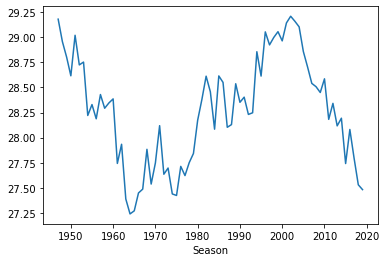

In [4]:
mean_age_by_war = get_age_weighted_by_category(batting, 'WAR')
mean_age_by_war.plot()
mean_age_by_war

OK, we can see some trends, but a lot of bouncing around by year.  Which makes sense, because the pool of players is aging every year, and it's turning over, but not uniformly.  Let's use rolling averages to see the broader trends.  Let's start with a 20-year rolling average to see the long arc of time.

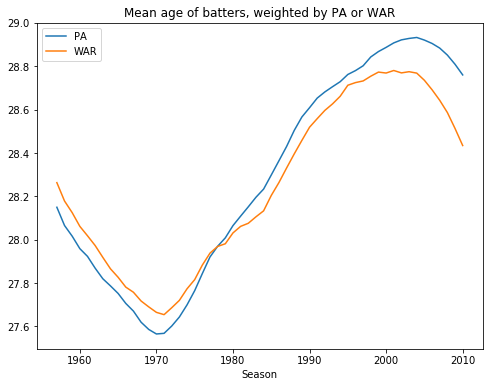

In [5]:
# Let's start with the long arcs of time: 20-year rolling averages for mean age, weighted by PA and WAR
def plot_rolling_weighted_age(data, stats, window, title="Mean age of batters, weighted"):
    mean_ages = [get_age_weighted_by_category(data, stat).rolling(window=window, center=True).mean() for stat in stats]
    pd.concat(mean_ages, axis=1).plot.line(figsize=(8,6), title=title)

plot_rolling_weighted_age(batting, ['PA', 'WAR'], 20, "Mean age of batters, weighted by PA or WAR")

OK, we can generally see three eras: the game getting younger from integration through about 1970, then aging for three decades, and then getting younger again in the 21st century.

The two curves basically show the same trends.  Let's take a brief aside, and see how we can use the same concept of mean age to reveal other trends about the game.  For example, we can see what kind of value is provided by players of different ages.  'Bat', 'Def' and 'Pos' are the batting, defensive and positional components of WAR.  Notice how teams have always gotten their batting value from older players than defense (though the same long-term aging and youth trends over time are visible):

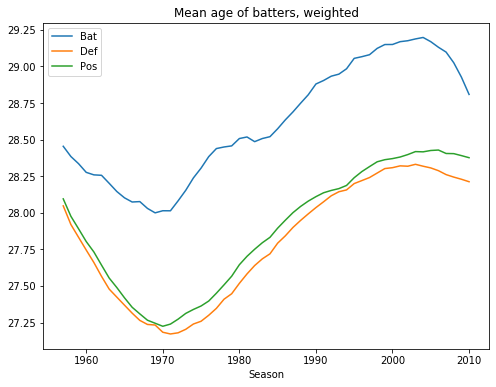

In [6]:
plot_rolling_weighted_age(batting, ['Bat', 'Def', 'Pos'], 20)


OK, let's go back to age trends over time, specifically to see how the current day compares historically.  From the earlier, 20-year graph, it was clear that the league has been getting younger from its peak, but it didn't appear to be younger than '80s/'90s levels.  We can look at shorter windows to get a better view of the more minor fluctuations, and we see that the trend towards youth has been so strong that the league is as young as it was in the 1970s.

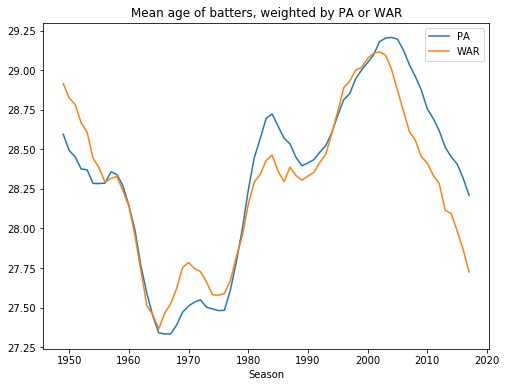

In [7]:
plot_rolling_weighted_age(batting, ['PA', 'WAR'], 5, "Mean age of batters, weighted by PA or WAR")

### Age Distribution Curves

The mean age gives us a way to summarize the age of a player pool with a single number, so we can easily see trends over time.  Alternatively, we can get a more detailed view of the distribution of playing time or output by age, looking at a fixed set of years.  For example, here is the age distribution curve for PA for all years since integration:

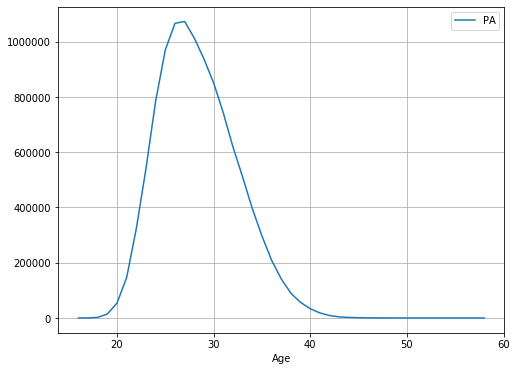

In [8]:
# Generate an age distribution curve for a chosen stat
def get_age_curve(data, stat):
    stats = data[data[stat]>0][['Age', stat]]
    return stats.groupby(['Age']).sum()

get_age_curve(batting, 'PA').plot.line(figsize=(8,6), grid=True)

That's about what we expect: most of the playing time goes to players between 24-32, peaking around 27, with tails into the teens and forties.

Where it gets interesting is when we overlay age curves from two different eras, to see how things have changed.  Looking back at the mean age curves from last section, we can see that the aging trend peaked in the early 2000s (let's say 2000-04), so let's compare that to the most recent 5 years:

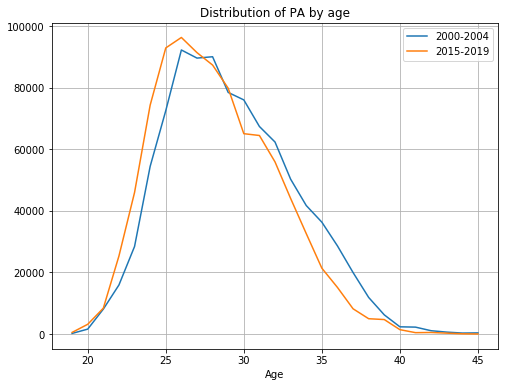

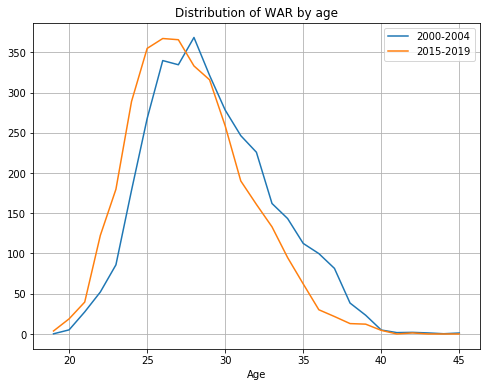

In [9]:

# Generate an age distribution curve for a chosen stat, from a range of years
def get_age_curve_from_years(data, stat, year_start, year_end):
    data_yrs = data[data['Season'].isin(range(year_start,year_end+1))]
    return get_age_curve(data_yrs, stat).rename(columns={stat:f'{year_start}-{year_end}'})

# Compare the distribution curves from the early 2000s to the late 2010s
for stat in ['PA', 'WAR']:
    ranges = [(2000, 2004), (2015, 2019)]
    age_curves = [get_age_curve_from_years(batting, stat, yr_start, yr_end) for (yr_start, yr_end) in ranges]
    pd.concat(age_curves, axis=1).fillna(0).plot.line(figsize=(8,6), title=f'Distribution of {stat} by age', grid=True)


We can see that the curves are generally shaped the same, but clearly shifted left.  It looks like the PA curve has moved left by about a year, and the WAR curve movement is even more prominent, around two years.  Or looking vertically, to see how much production has varied by age: it appears that half the value of players 33+ has disappeared, while that of 25+ has roughly doubled.

Another way to look at this is cumulative WAR by age.  How much age is earned by players age X and lower?

,2000-2004,2015-2019
Age,,
19.0,0.2,3.7
20.0,5.3,22.5
21.0,32.7,62.1
22.0,84.8,184.5
23.0,170.7,364.3
24.0,349.2,653.2
25.0,616.8,1008.0
26.0,956.5,1375.1
27.0,1291.0,1740.7


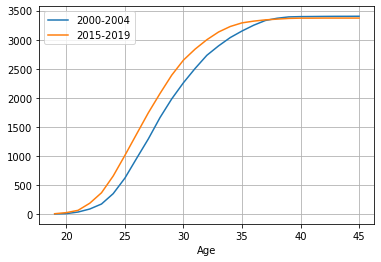

In [10]:
ranges = [(2000, 2004), (2015, 2019)]
age_curves = [get_age_curve_from_years(batting, 'WAR', yr_start, yr_end) for (yr_start, yr_end) in ranges]
war_by_age = pd.concat(age_curves, axis=1).fillna(0)
cum_war_by_age = war_by_age.cumsum()
cum_war_by_age.plot(grid=True)
cum_war_by_age

Players 25 and under are earning 60% more WAR these days than they were at the beginning of the century.  The lead for young players peaks at age 27, where today's young players are 450 WAR ahead of their predecessors.

A better way to look at the value provided by old players is essentially the reverse of this: WAR remaining by age.

,2000-2004,2015-2019
Age,,
19.0,3403.4,3368.4
20.0,3398.3,3349.6
21.0,3370.9,3310.0
22.0,3318.8,3187.6
23.0,3232.9,3007.8
24.0,3054.4,2718.9
25.0,2786.8,2364.1
26.0,2447.1,1997.0
27.0,2112.6,1631.4


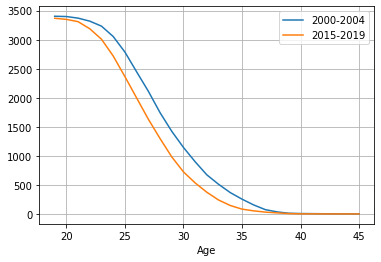

In [11]:
remaining_war_by_age = cum_war_by_age.max()-cum_war_by_age
remaining_war_by_age.plot(grid=True)
remaining_war_by_age

Modern teams are getting half the value from 33+ year old players than their predecessors early in the century were.